In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import math
from scipy import signal
from scipy.fftpack import fft
from scipy import ndimage
from scipy import special
import math
%matplotlib inline

In [2]:
##Temporal kernal
def temporal(t):
    k1 = 2.2
    sigma_1 = 1
    u1 = 3
    k2 = 2
    sigma_2 = 2
    u2 = 8
    kernal1 = (k1/np.sqrt(2*np.pi)/sigma_1)*np.exp(-(t-u1)**2/(2*sigma_1**2))
    kernal2 = (k2/np.sqrt(2*np.pi)/sigma_2)*np.exp(-(t-u2)**2/(2*sigma_2**2))
    return kernal1-kernal2

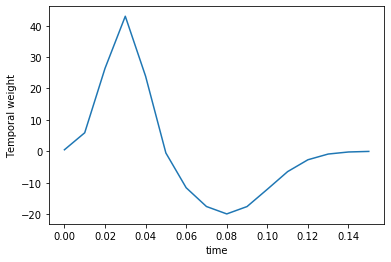

In [25]:
#Make Temporal kernal
length = 15
dt = 0.01
tp = temporal(np.arange(0,length+1))
tp = tp*50
plt.plot(np.arange(0,length+1)*dt,tp)
plt.xlabel('time')
plt.ylabel('Temporal weight')
temp_pre = np.zeros(length)
tp = np.concatenate((temp_pre,tp))

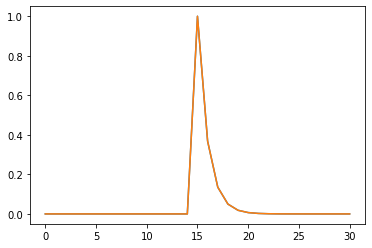

In [43]:
#Make Temporal kernal
length = 15
dt = 0.01
tp1 = temporal(np.arange(0,length+1))
tp1 = tp1*50

for i in range(len(tp1)):
    tp1[i]= np.exp(-i/1)
temp_pre = np.zeros(length)
tp1 = np.concatenate((temp_pre,tp1))
tp1[0]=0
plt.plot(tp1)
tp = tp1.copy()
plt.plot(tp)

In [44]:
#Spatial kernal
def spatial(x,u):
    sigma_1 = 0.5
    sigma_2 = 2
    kernal1 = (3.5/np.sqrt(2*np.pi)/sigma_1)*np.exp(-(x-u)**2/(2*sigma_1**2))
    kernal2 = (3/np.sqrt(2*np.pi)/sigma_2)*np.exp(-(x-u)**2/(2*sigma_2**2))
    return kernal1-kernal2
    #return kernal2-kernal1

Text(0, 0.5, 'Spatial weight')

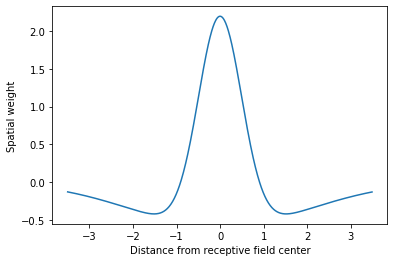

In [45]:
#Make Spatial kernal
sigma_c = 1#RF size of horizontal cell
dx = 0.01*sigma_c
sk = spatial(np.arange(-3.5*sigma_c,3.5*sigma_c,dx),0)
plt.plot(np.arange(-3.5*sigma_c,3.5*sigma_c,dx),sk)
plt.xlabel('Distance from receptive field center')
plt.ylabel('Spatial weight')

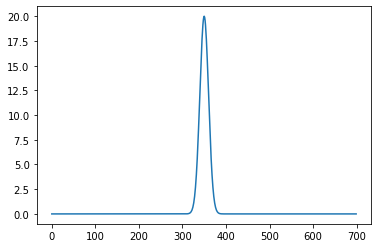

In [174]:
sk1 = np.zeros(len(sk))
mid = int(len(sk)/2)
for i in range(len(sk1)):
    sk1[i]= np.exp(-0.005*(i-350)**2)*20
    
plt.plot(sk1)
sk = sk1.copy()

In [175]:
#Gain control function
def gain(v,order,B):
    if v <0:
        return 1
    else:
        return 1/(1+(B*v)**order)

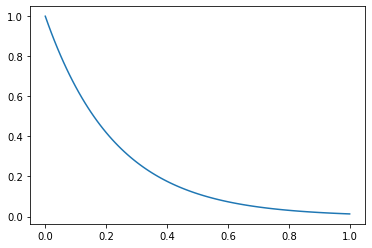

In [176]:
#Feedback filter for u
tau = 0.23#sec
feedback_filter = np.exp(-np.arange(0,1+dt,dt)/tau)
plt.plot(np.arange(0,1+dt,dt),feedback_filter)

In [177]:
#Width setting
xlen = 15*sigma_c#spatial extend of simulation
hw = 0.5*sigma_c#half bar width

In [178]:
pos_0 = 1.5*sigma_c#Where the bar start
nstep = 1000#time step of simulation
velocity = 1*sigma_c#speed of bar
order = 4#Order of gain control
B = 35#To tune altitude of gain control
contrast = 1#Contrast of bar

In [179]:
real_len = int(xlen/dx)#spatial width
s = np.zeros([real_len,nstep])#stimulus
u = np.zeros([real_len,nstep])#Output
gains = np.zeros([real_len,nstep])#Gain values
for i in range(nstep):
    #Bar position
    pos = pos_0+velocity*dt*i
    #Stimulus of bar
    s[int((pos-hw)/dx):int((pos+hw)/dx),i] = contrast

In [180]:
##Produce spatial-temporal filter
temp = np.zeros([real_len,nstep])
spatial_temp1 = np.zeros([real_len,nstep])
for i in range(nstep):
    temp[:,i] = np.convolve(s[:,i],sk,'same')*dx
for j in range(real_len):
    spatial_temp1[j,:] = np.convolve(tp,temp[j,:],'same')*dt
temp = np.zeros([real_len,nstep])
spatial_temp2 = np.zeros([real_len,nstep])#Linear filter output, this represents convolution between input and spatial-temporal filter
for j in range(real_len):
    temp[j,:] = np.convolve(tp,s[j,:],'same')*dt
for i in range(nstep):
    spatial_temp2[:,i] = np.convolve(temp[:,i],sk,'same')*dx

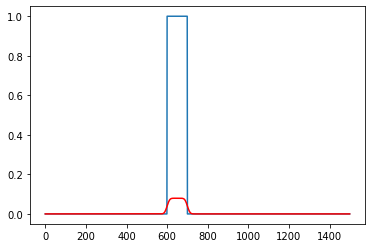

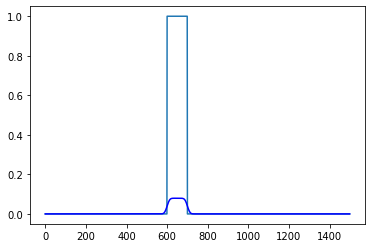

In [181]:
##Make sure the spatial-temporal filter is right
k = 500
plt.plot(s[:,k])
plt.plot(spatial_temp1[:,k],'r')
plt.figure()
plt.plot(s[:,k])
plt.plot(spatial_temp2[:,k],'b')

In [187]:
#######Main part##########
B = 35*2
for i in range(len(feedback_filter),nstep,1):
    for j in range(real_len):
        v = np.convolve(feedback_filter,spatial_temp1[j,i-len(feedback_filter)+1:i+1],'valid')*dt#average by expotential filtering
        g = gain(v,order,B)#Gain control
        spatial_temp1[j,i] = spatial_temp1[j,i]*g
        u[j,i] = spatial_temp1[j,i]#*g
        gains[j,i] = g

In [188]:
###Nonlinearity
u[u<0]= 0####Make negative number to zero

Without gain control, the prediction is 0.0
With gain control, the prediction is 36.0


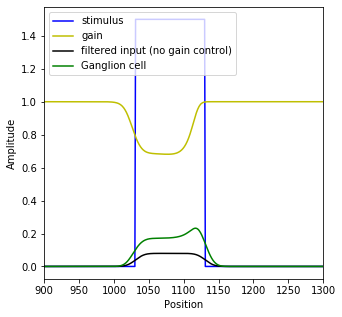

In [189]:
k = 931
plt.figure()
plt.plot(s[:,k]*1.5,'b',label='stimulus')
plt.plot(gains[:,k],'y',label='gain')
plt.plot(spatial_temp2[:,k],'k',label='filtered input (no gain control)')##Linear filter output without gain control
plt.plot(u[:,k]*3.5,'g',label='Ganglion cell')
plt.xlabel('Position')
plt.ylabel('Amplitude')
plt.legend(loc='upper left')
plt.xlim([900,1300])
#plt.ylim([0,0.5])
plt.gcf().set_size_inches(5,5)
u_maxpos = np.argmax(u[:,k])
spatial_temp_maxpos = np.argmax(spatial_temp2[:,k])
pos = pos_0+velocity*dt*k
print('Without gain control, the prediction is '+str(spatial_temp_maxpos-pos/dx))
print('With gain control, the prediction is '+str(u_maxpos-pos/dx))
#plt.savefig('gain_control.jpg')

In [190]:
#np.save('Berry_extra.npy',u)

In [191]:
B

70